In [0]:
# date set is balanced

In [0]:
# library import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [0]:
# define hyperparameters and functions
batch_size = 100
num_epoches = 100

window_step = 5
window_length = 10

learning_rate = 1e-3
betas=(0.9, 0.999)
weight_decay=1e-3


index = np.arange(2115)
np.random.shuffle(index)
training_index, valid_index = index[:1715], index[1715:]

train_acc = []
test_acc = []


use_gpu = torch.cuda.is_available()  # determine whether it has gpu speed up


def plot_acc(train_acc, test_acc):
    plt.plot(test_acc, label = "test")
    plt.plot(train_acc, label = "train")
    plt.xlabel("eopch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("The accuracy against epoch")
    plt.show()


def flatten(x):
    """
    Input:
    - Tensor of shape (N, D1, ..., DM)
    Output:
    - Tensor of shape (N, D1 * ... * DM)
    """
    x_shape = x.size()
    new_shape = 1
    for i in range(len(x_shape) - 1):
        new_shape *= x_shape[i + 1]
    x_flat = x.reshape((x_shape[0],new_shape))
    return x_flat

In [27]:
# load data into environment
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
person_train_valid = np.load("data/person_train_valid.npy")
X_train_valid = np.load("data/X_train_valid.npy")
y_train_valid = np.load("data/y_train_valid.npy")
person_test = np.load("data/person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
# transform data into pytorch form
# extract first 22 signals out of 25 signals
X_train_valid = X_train_valid[:, :22, :]
X_train = X_train_valid[training_index]
X_valid = X_train_valid[valid_index]
X_test = X_test[:, :22, :]


# standardize data
X_train = X_train.reshape((1715, 22*1000))
X_valid = X_valid.reshape((400, 22*1000))
X_test = X_test.reshape((443, 22*1000))

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((1715, 22, 1000))
X_valid = X_valid.reshape((400, 22, 1000))
X_test = X_test.reshape((443, 22, 1000))

y_train = y_train_valid[training_index]
y_valid = y_train_valid[valid_index]


trainset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train - 769).long())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validset = torch.utils.data.TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid - 769).long())
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test - 769).long())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


In [0]:
# network architecture
class eeg_lstm(nn.Module):
     def __init__(self, in_feature=22, hidden_feature=32, num_class=4, signal_length=1000):
          super(eeg_lstm, self).__init__()
          self.rnn = nn.LSTM(input_size=in_feature, hidden_size=hidden_feature, num_layers=1) #using 5 layers lstm
          self.relu = nn.ReLU()
          self.dropout = nn.Dropout(0.5)
          self.classifier = nn.Linear(hidden_feature*signal_length, num_class) #using linear to classify the output
          
     def forward(self, x):
          out, _ = self.rnn(x) #使用默认的隐藏状态，得到的out是（1000， batch， hidden_feature）
          #print(out.shape)
          out = self.dropout(out)
          out = self.relu(out)
          out = self.dropout(out)
          #out = out[-101:-1,:,:]#取序列中的最后一个，大小是（batch， hidden_feature)
          out = flatten(out.permute(1, 0, 2))
          #print(out.shape)
          out = self.classifier(out) #得到分类结果
          #tag_score = F.log_softmax(out, dim=1)
          return out

In [0]:
# initiate lstm network
model = eeg_lstm()  
if use_gpu:
    model = model.cuda()


# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# parameters in Adam could be tuned
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)

epoch 1
**********
Finish 1 epoch, Loss: 1.409526, Acc: 0.293294
Validation Loss: 1.415672, Acc: 0.267500

epoch 2
**********
Finish 2 epoch, Loss: 1.243294, Acc: 0.430904
Validation Loss: 1.282983, Acc: 0.392500

epoch 3
**********
Finish 3 epoch, Loss: 1.078174, Acc: 0.563265
Validation Loss: 1.252986, Acc: 0.425000

epoch 4
**********
Finish 4 epoch, Loss: 0.929154, Acc: 0.630904
Validation Loss: 1.192165, Acc: 0.467500

epoch 5
**********
Finish 5 epoch, Loss: 0.777462, Acc: 0.706706
Validation Loss: 1.200045, Acc: 0.487500

epoch 6
**********
Finish 6 epoch, Loss: 0.669041, Acc: 0.751603
Validation Loss: 1.245375, Acc: 0.460000

epoch 7
**********
Finish 7 epoch, Loss: 0.605794, Acc: 0.777843
Validation Loss: 1.187858, Acc: 0.507500

epoch 8
**********
Finish 8 epoch, Loss: 0.518040, Acc: 0.821574
Validation Loss: 1.212392, Acc: 0.492500

epoch 9
**********
Finish 9 epoch, Loss: 0.479641, Acc: 0.837318
Validation Loss: 1.275182, Acc: 0.510000

epoch 10
**********
Finish 10 epoch, 

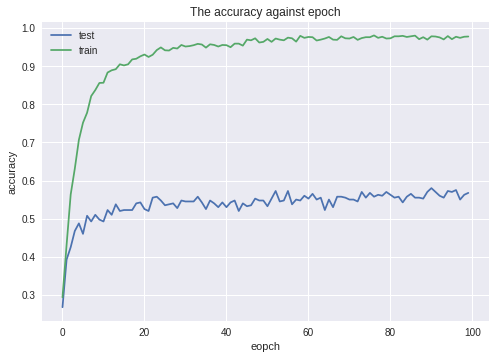

Test Loss: 1.825393, Acc: 0.528217



In [31]:
# start training and evaluating models
for epoch in range(num_epoches):  # again, normally you would NOT do 300 epochs, it is toy data
    model.train()
    print('epoch {}'.format(epoch + 1))
    print('*' * 10)
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (signals, tags) in enumerate(trainloader):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        signals = signals.squeeze(1)
        signals = signals.permute(2, 0, 1)
        if use_gpu:
            signals = Variable(signals).cuda()
            tags = Variable(tags).cuda()
        else:
            signals = Variable(signals)
            tags = Variable(tags)

        # Step 3. Run our forward pass.
        tag_scores = model(signals)
        
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(tag_scores, tags)
        running_loss += loss.data.item() * tags.size(0)
        _, pred = torch.max(tag_scores, 1)
        num_correct = (pred == tags).sum()
        running_acc += num_correct.data.item()
        # 向后传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Finish {} epoch, Loss: {:.6f}, Acc: {:.6f}'.format(
        epoch + 1, running_loss / (len(X_train)), running_acc / (len(
            X_train))))
    train_acc.append(running_acc / (len(X_train)))
    
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    for batch_idx, (signals, tags) in enumerate(validloader):
        
        signals = signals.squeeze(1)
        signals = signals.permute(2, 0, 1)
        if use_gpu:
            signals = Variable(signals).cuda()
            tags = Variable(tags).cuda()
        else:
            signals = Variable(signals)
            tags = Variable(tags)

        tag_scores = model(signals)
        loss = criterion(tag_scores, tags)
        eval_loss += loss.data.item() * tags.size(0)
        _, pred = torch.max(tag_scores, 1)
        num_correct = (pred == tags).sum()
        eval_acc += num_correct.data.item()
    print('Validation Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
        X_valid)), eval_acc / (len(X_valid))))
    test_acc.append(eval_acc / (len(X_valid)))
    print()

plot_acc(train_acc, test_acc)    

file = open('standardize.txt', 'a+')
s = ""
for e in test_acc:
  s+=str(e)
  s+=','
s+='\n'
file.writelines(s)
file.close()

eval_loss = 0.
eval_acc = 0.
for batch_idx, (signals, tags) in enumerate(testloader):
        
    signals = signals.squeeze(1)
    signals = signals.permute(2, 0, 1)
    if use_gpu:
        signals = Variable(signals).cuda()
        tags = Variable(tags).cuda()
    else:
        signals = Variable(signals)
        tags = Variable(tags)

    tag_scores = model(signals)
    loss = criterion(tag_scores, tags)
    eval_loss += loss.data.item() * tags.size(0)
    _, pred = torch.max(tag_scores, 1)
    num_correct = (pred == tags).sum()
    eval_acc += num_correct.data.item()
print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
        X_test)), eval_acc / (len(X_test))))
print()

        